# _Does Temperature Affect Covid-19 Spread?_
____

In [1]:
# Dependencies

import pandas as pd
import numpy as np

%matplotlib notebook
from matplotlib import pyplot as plt
from scipy.stats import linregress

import requests
import json

# Import api keys for weather and gmaps
from config import (weather_key, g_key)

# Import and access maps with API key
import gmaps
gmaps.configure(api_key = g_key)

from datetime import datetime

#import time
#from us import states


## _Countrywise Covid-19 Data_

___

In [2]:
# Loading raw Covid-19 data for countries

Covid_global_data = pd.read_csv("Resources/Covid19_Global.csv")

Covid_global_data = Covid_global_data.drop(['Province/State'], axis=1)

# Sorting the data by latest case_count
Covid_global_data = Covid_global_data.sort_values("04/02/2020", ascending = False)

# Dropping few countries
# (Ex:china as it almost reached peak count for this time frame)
Covid_global_data = Covid_global_data.drop([62,42,143])


# Selecting top 30 affected countries
Covid_global_data = Covid_global_data.iloc[:31,:]

# Resetting the index 
Covid_global_data.reset_index(inplace = True, drop = True)

Covid_global_data


,Country,Latitude,Longitude,01/22/2020,01/23/2020,01/24/2020,01/25/2020,01/26/2020,01/27/2020,01/28/2020,...,03/24/2020,03/25/2020,03/26/2020,03/27/2020,03/28/2020,03/29/2020,03/30/2020,03/31/2020,04/01/2020,04/02/2020
0,US,37.0902,-95.7129,1,1,2,2,5,5,5,...,53740,65778,83836,101657,121478,140886,161807,188172,213372,243453
1,Italy,43.0000,12.0000,0,0,0,0,0,0,0,...,69176,74386,80589,86498,92472,97689,101739,105792,110574,115242
2,Spain,40.0000,-4.0000,0,0,0,0,0,0,0,...,39885,49515,57786,65719,73235,80110,87956,95923,104118,112065
3,Germany,51.0000,9.0000,0,0,0,0,0,1,4,...,32986,37323,43938,50871,57695,62095,66885,71808,77872,84794
4,France,46.2276,2.2137,0,0,2,3,3,3,4,...,22304,25233,29155,32964,37575,40174,44550,52128,56989,59105
5,Iran,32.0000,53.0000,0,0,0,0,0,0,0,...,24811,27017,29406,32332,35408,38309,41495,44605,47593,50468
6,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,0,...,8077,9529,11658,14543,17089,19522,22141,25150,29474,33718
7,Switzerland,46.8182,8.2275,0,0,0,0,0,0,0,...,9877,10897,11811,12928,14076,14829,15922,16605,17768,18827
8,Turkey,38.9637,35.2433,0,0,0,0,0,0,0,...,1872,2433,3629,5698,7402,9217,10827,13531,15679,18135
9,Belgium,50.8333,4.0000,0,0,0,0,0,0,0,...,4269,4937,6235,7284,9134,10836,11899,12775,13964,15348


### _Extracting temperatures for countries_

In [3]:
# Country_temperatures 

base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID="

# Retrieving latitudes and longitudes

lats = Covid_global_data["Latitude"]
lngs = Covid_global_data["Longitude"]

lat_lngs = zip(lats, lngs)

# Create a list to store temperatures

temperatures = []

# Aquiring temperatures by making api calls

for lat_lng in lat_lngs:
    
    query_url = f'{base_url}{weather_key}&lat={lat_lng[0]}&lon={lat_lng[1]}'
    
    results = requests.get(query_url).json()
    
    country_temp = results["main"]["temp"]
    
    temperatures.append(country_temp)
    
# Add temperatures to "Temperature" column 

Covid_global_data["Temp(F)"] = temperatures

### _Extracting Population density(Persons per SqKm) for Countries_

In [4]:
# Loading raw data for population 
Population_global_data = pd.read_csv("Resources/Population_global_data.csv")

# Extracting required rows and columns from raw data
Population_global_data = Population_global_data.iloc[0:193, [1,4,7]] 

# Renaming Column names
Population_global_data = Population_global_data.rename(columns={"country": "Country",
                                                                "pop": "Population",
                                                                "density": "Pop_density"
                                                               })

# Dropping duplicate values
Population_global_data = Population_global_data.drop_duplicates(subset = 'Country', keep='first')

# Resetting the index 
Population_global_data.reset_index(inplace = True, drop = True)

Population_global_data

,Country,Population,Pop_density
0,Afghanistan,"38,928,346",60.0
1,Albania,"2,877,797",105.0
2,Algeria,"43,851,044",18.0
3,Andorra,"77,265",164.0
4,Antigua and Barbuda,"97,929",223.0
...,...,...,...
171,Uzbekistan,"33,469,203",79.0
172,Venezuela,"28,435,940",32.0
173,Vietnam,"97,338,579",314.0
174,Zambia,"18,383,955",25.0


In [7]:
# Merge Covid global data and population global data

Covid_global_data = pd.merge(Covid_global_data, Population_global_data, 
                             on = "Country", how = 'left')

# Rearranging columns in the desired order
Covid_global_data = Covid_global_data[["Country","Latitude", "Longitude",
                                       "Temp(F)","Population","Pop_density",
                                       "01/22/2020","01/23/2020","01/24/2020",
                                       "01/25/2020","01/26/2020","01/27/2020",
                                       "01/28/2020","01/29/2020","01/30/2020",
                                       "01/31/2020","02/01/2020","02/02/2020",
                                       "02/03/2020","02/04/2020","02/05/2020",
                                       "02/06/2020","02/07/2020","02/08/2020",
                                       "02/09/2020","02/10/2020","02/11/2020",
                                       "02/12/2020","02/13/2020","02/14/2020",
                                       "02/15/2020","02/16/2020","02/17/2020",
                                       "02/18/2020","02/19/2020","02/20/2020",
                                       "02/21/2020","02/22/2020","02/23/2020",
                                       "02/24/2020","02/25/2020","02/26/2020",
                                       "02/27/2020","02/28/2020","02/29/2020",
                                       "03/01/2020","03/02/2020","03/03/2020",
                                       "03/04/2020","03/05/2020","03/06/2020",
                                       "03/07/2020","03/08/2020","03/09/2020",
                                       "03/10/2020","03/11/2020","03/12/2020",
                                       "03/13/2020","03/14/2020","03/15/2020",
                                       "03/16/2020","03/17/2020","03/18/2020",
                                       "03/19/2020","03/20/2020","03/21/2020",
                                       "03/22/2020","03/23/2020","03/24/2020",
                                       "03/25/2020","03/26/2020","03/27/2020",
                                       "03/28/2020","03/29/2020","03/30/2020",
                                       "03/31/2020","04/01/2020","04/02/2020"
                                       ]]

Covid_global_data

,Country,Latitude,Longitude,Temp(F),Population,Pop_density,01/22/2020,01/23/2020,01/24/2020,01/25/2020,...,03/24/2020,03/25/2020,03/26/2020,03/27/2020,03/28/2020,03/29/2020,03/30/2020,03/31/2020,04/01/2020,04/02/2020
0,US,37.0902,-95.7129,70.52,"331,002,651",36.0,1,1,2,2,...,53740,65778,83836,101657,121478,140886,161807,188172,213372,243453
1,Italy,43.0000,12.0000,50.14,"60,461,826",206.0,0,0,0,0,...,69176,74386,80589,86498,92472,97689,101739,105792,110574,115242
2,Spain,40.0000,-4.0000,59.79,"46,754,778",94.0,0,0,0,0,...,39885,49515,57786,65719,73235,80110,87956,95923,104118,112065
3,Germany,51.0000,9.0000,51.46,"83,783,942",240.0,0,0,0,0,...,32986,37323,43938,50871,57695,62095,66885,71808,77872,84794
4,France,46.2276,2.2137,50.54,"65,273,511",119.0,0,0,2,3,...,22304,25233,29155,32964,37575,40174,44550,52128,56989,59105
5,Iran,32.0000,53.0000,63.01,"83,992,949",52.0,0,0,0,0,...,24811,27017,29406,32332,35408,38309,41495,44605,47593,50468
6,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,0,0,0,0,...,8077,9529,11658,14543,17089,19522,22141,25150,29474,33718
7,Switzerland,46.8182,8.2275,46.33,"8,654,622",219.0,0,0,0,0,...,9877,10897,11811,12928,14076,14829,15922,16605,17768,18827
8,Turkey,38.9637,35.2433,46.40,"84,339,067",110.0,0,0,0,0,...,1872,2433,3629,5698,7402,9217,10827,13531,15679,18135
9,Belgium,50.8333,4.0000,54.99,"11,589,623",383.0,0,0,0,0,...,4269,4937,6235,7284,9134,10836,11899,12775,13964,15348


## _Scatter plots & Bar Charts_

In [8]:
# Storing required values to plot scatter plots and bar graphs

countries = Covid_global_data["Country"]
temperatures = Covid_global_data["Temp(F)"]
Covid_cases = Covid_global_data["04/02/2020"]
pop_density = Covid_global_data["Pop_density"]

### _Scatter plot for Temperature Vs. Covid Cases_

<IPython.core.display.Javascript object>


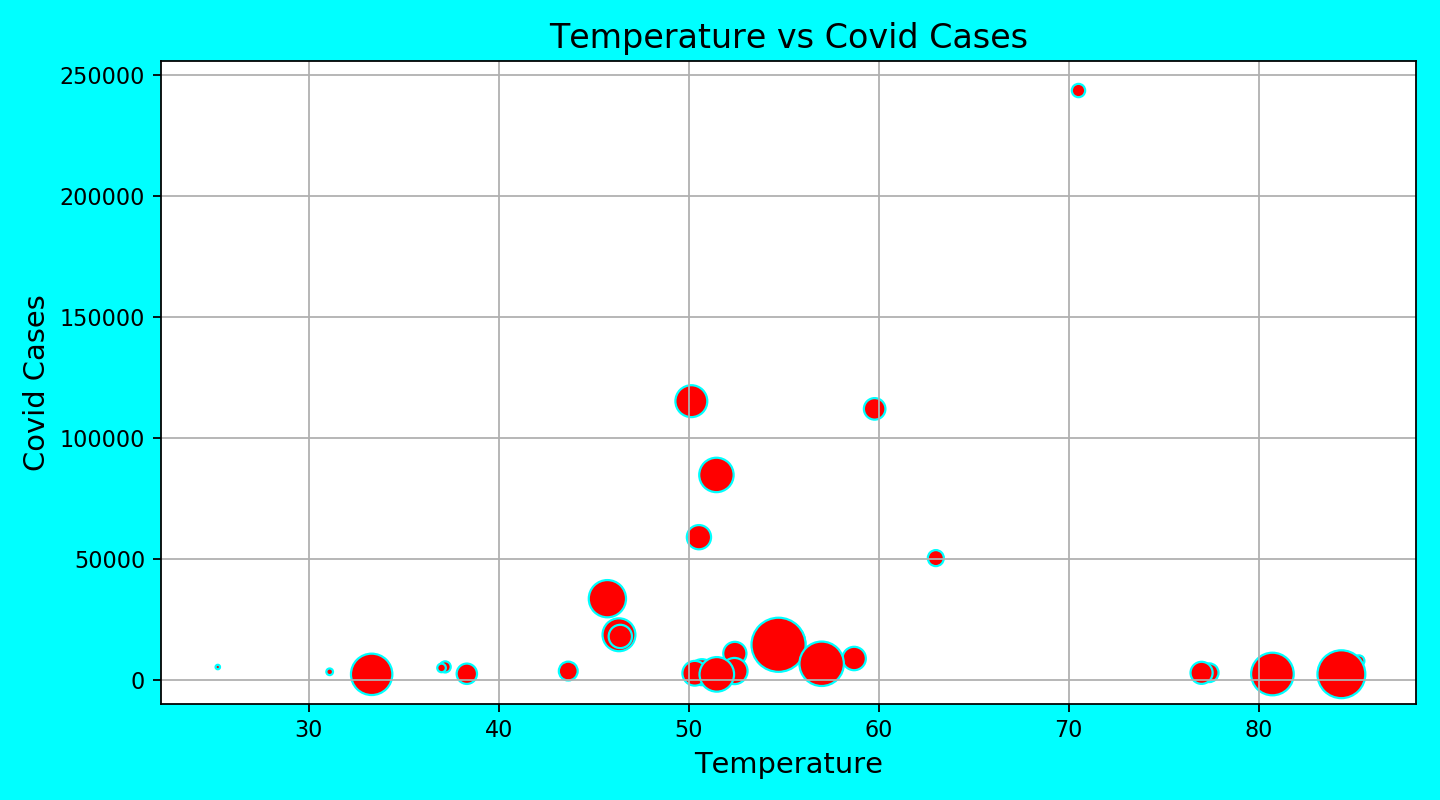

In [12]:
plt.figure(figsize=(9, 5), facecolor = 'cyan', edgecolor = 'b', dpi = 80)

plt.scatter (temperatures, Covid_cases,
             s = pop_density,
             marker="o",
             facecolors="red",
             edgecolors="cyan")

# Incorporate the other graph properties
plt.title("Temperature vs Covid Cases", color = "k", fontsize = 15)

plt.xlabel("Temperature", color = "k", fontsize = 13)
plt.ylabel("Covid Cases", color = "k", fontsize = 13)

#plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

### _Scatter plot for Population Density Vs. Covid Cases_

<IPython.core.display.Javascript object>


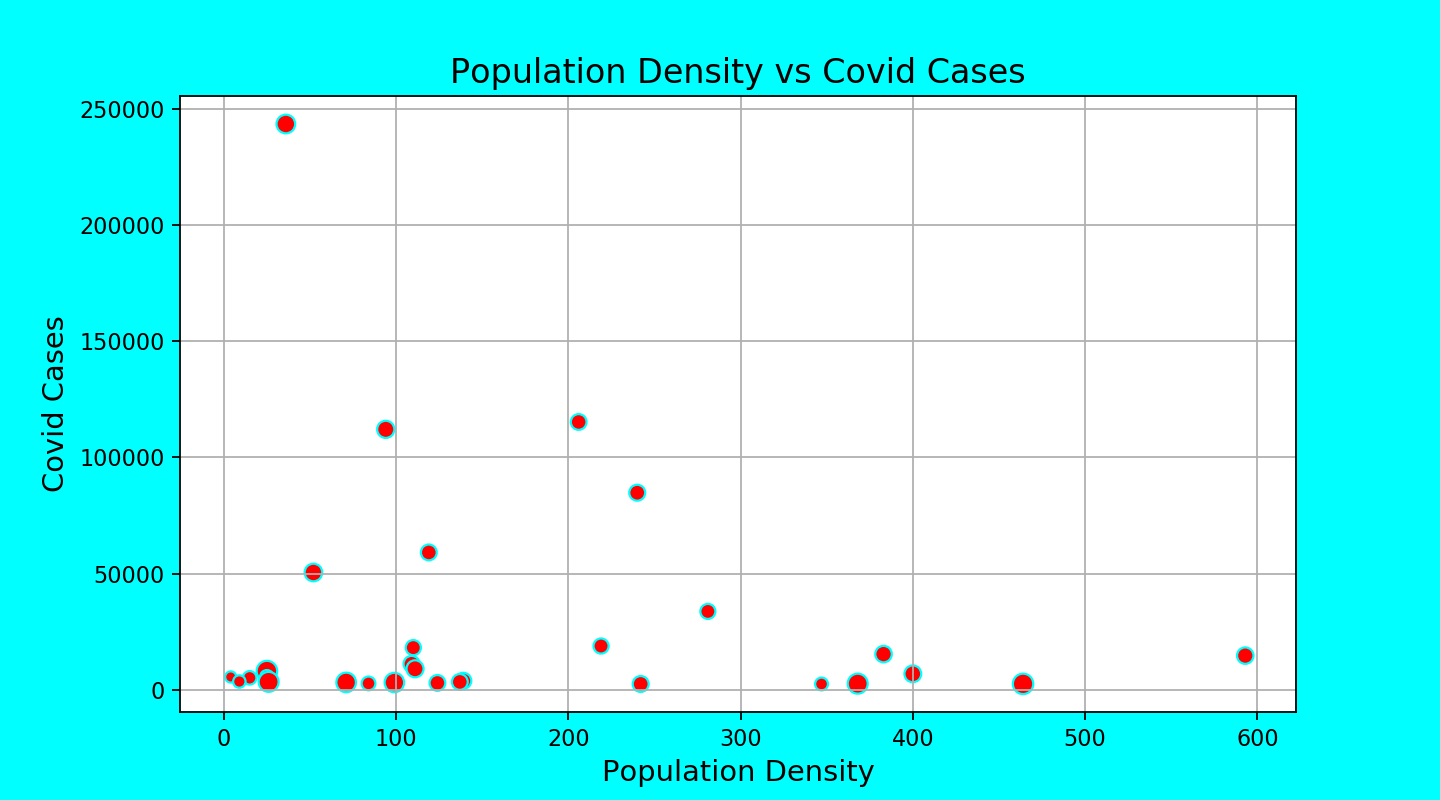

In [13]:
plt.figure(figsize = (9, 5), facecolor = 'cyan', edgecolor = 'b', dpi = 80)

plt.scatter(pop_density, Covid_cases,
             s = temperatures,
             marker = "o", 
             facecolors = "red", 
             edgecolors = "cyan")

# Incorporate the other graph properties

plt.title("Population Density vs Covid Cases", color = "k", fontsize = 15)

plt.xlabel("Population Density", color = "k", fontsize = 13)
plt.ylabel("Covid Cases", color = "k", fontsize = 13)

plt.grid(True)

plt.show()

### _Bar chart for Covid Cases in different countries_

<IPython.core.display.Javascript object>


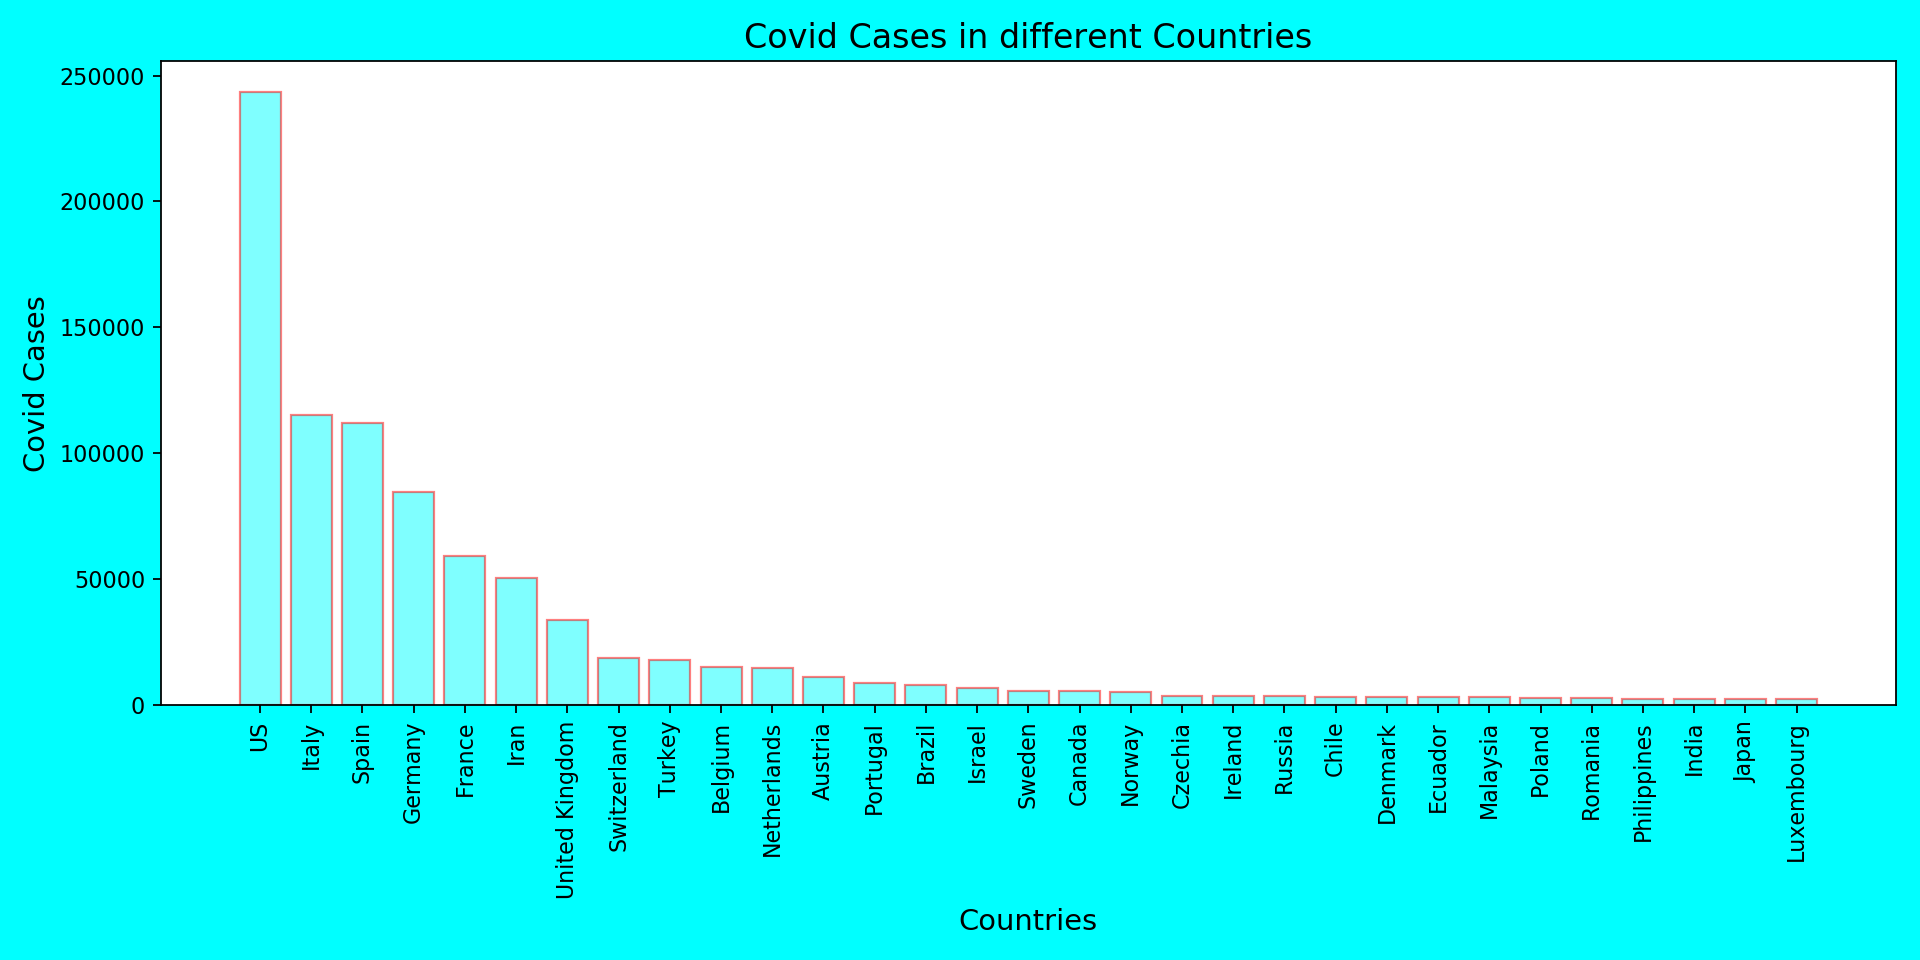

In [14]:
plt.figure(figsize = (12, 6), facecolor = 'cyan', edgecolor = 'b', dpi = 80)

plt.bar(countries, Covid_cases , color='cyan', edgecolor = 'red', alpha=0.5, align="center")

plt.title("Covid Cases in different Countries", color = "k", fontsize = 15)

plt.xlabel("Countries", color = "k", fontsize = 13)
plt.ylabel("Covid Cases", color = "k", fontsize = 13)

plt.xticks(rotation = "vertical")

plt.tight_layout()
plt.show()

### _Bar chart Population Densities of countries_

<IPython.core.display.Javascript object>


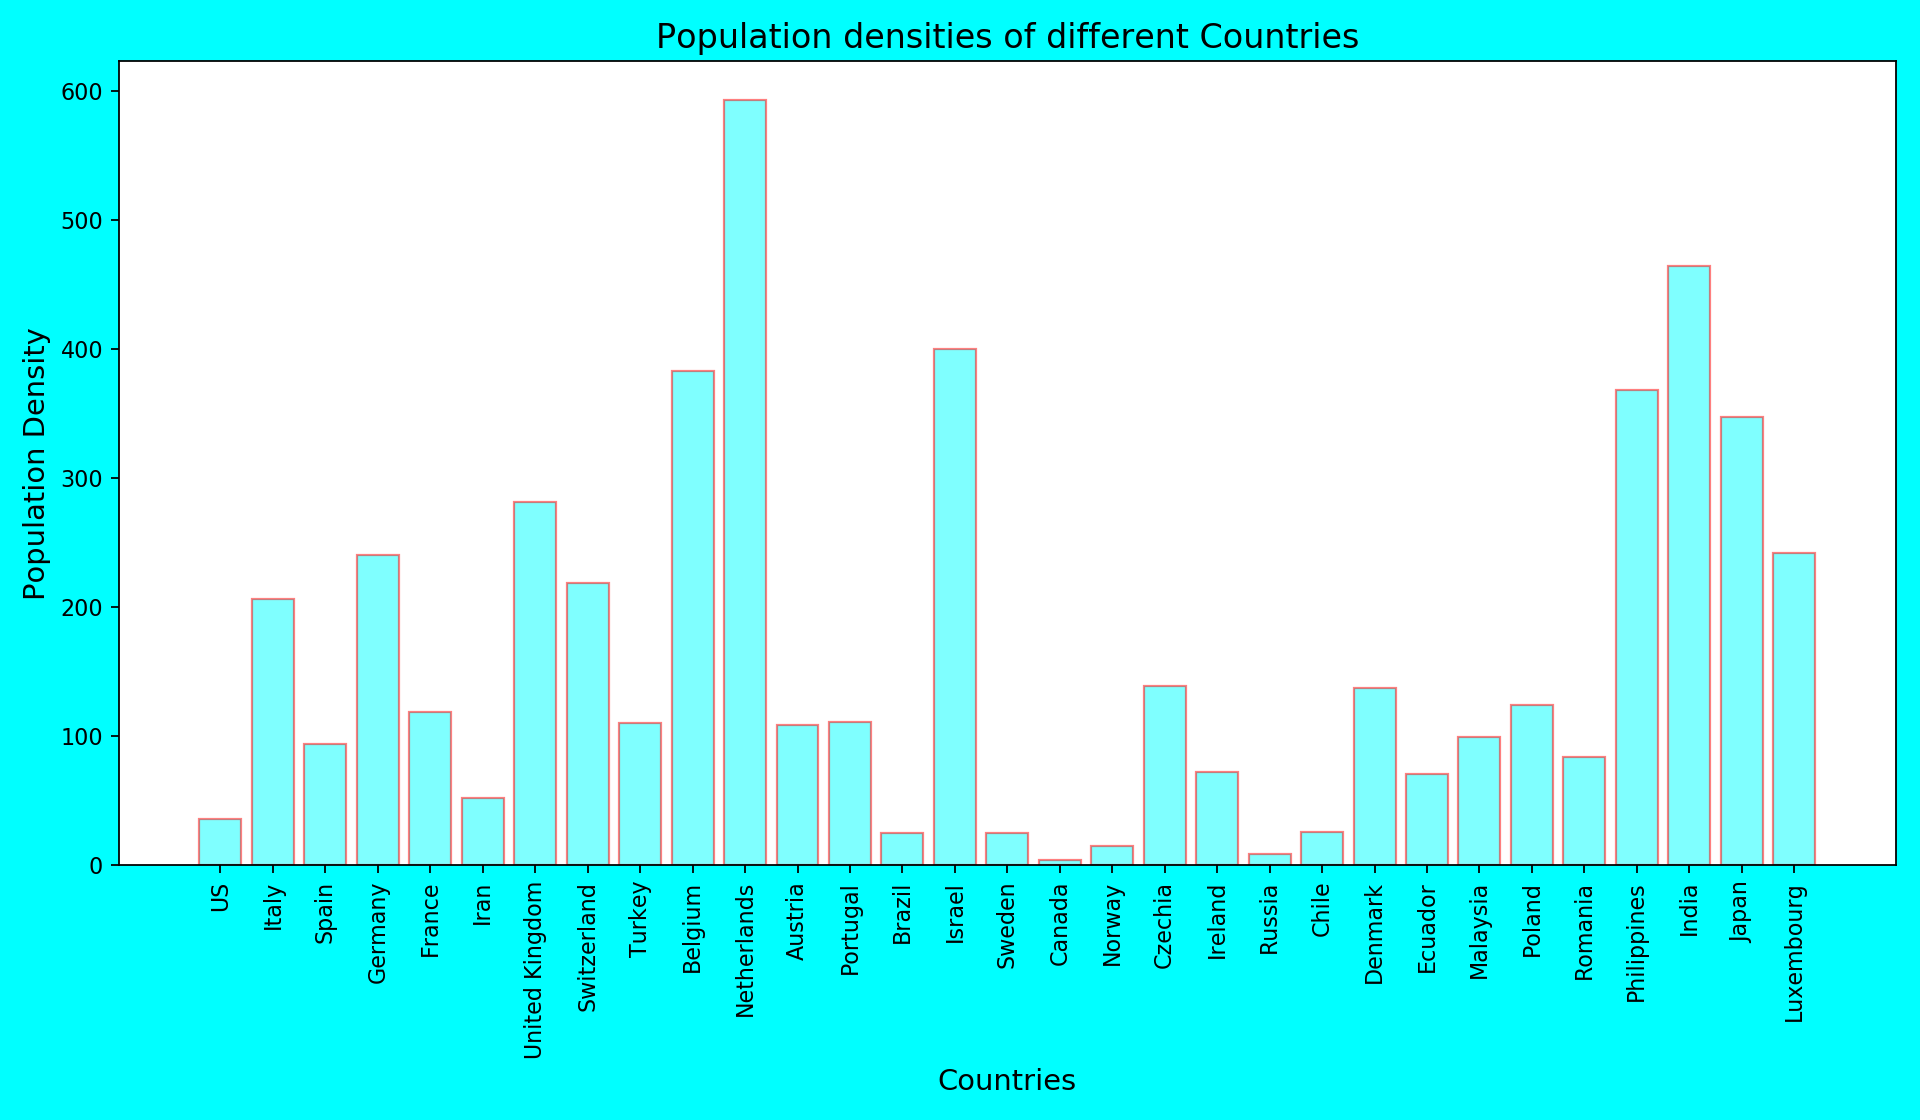

In [15]:
plt.figure(figsize = (12, 7), facecolor = 'cyan', edgecolor = 'b', dpi = 80)

plt.bar(countries,pop_density, color='cyan', edgecolor = 'red', alpha=0.5, align="center")

plt.title("Population densities of different Countries", color = "k", fontsize = 15)

plt.xlabel("Countries", color = "k", fontsize = 13)
plt.ylabel("Population Density", color = "k", fontsize = 13)

plt.xticks(rotation = "vertical")

plt.tight_layout()
plt.show()

___
# _Statistical Analysis for Covid-19 Vs Temperature_
___

In [17]:
Covid_global_stats = Covid_global_data.melt(id_vars = ["Country","Latitude", "Longitude",
                                                      "Temp(F)","Population","Pop_density"],
                                           
                                           value_vars = ["01/22/2020","01/23/2020","01/24/2020",
                                                         "01/25/2020","01/26/2020","01/27/2020",
                                                         "01/28/2020","01/29/2020","01/30/2020",
                                                         "01/31/2020","02/01/2020","02/02/2020",
                                                         "02/03/2020","02/04/2020","02/05/2020",
                                                         "02/06/2020","02/07/2020","02/08/2020",
                                                         "02/09/2020","02/10/2020","02/11/2020",
                                                         "02/12/2020","02/13/2020","02/14/2020",
                                                         "02/15/2020","02/16/2020","02/17/2020",
                                                         "02/18/2020","02/19/2020","02/20/2020",
                                                         "02/21/2020","02/22/2020","02/23/2020",
                                                         "02/24/2020","02/25/2020","02/26/2020",
                                                         "02/27/2020","02/28/2020","02/29/2020",
                                                         "03/01/2020","03/02/2020","03/03/2020",
                                                         "03/04/2020","03/05/2020","03/06/2020",
                                                         "03/07/2020","03/08/2020","03/09/2020",
                                                         "03/10/2020","03/11/2020","03/12/2020",
                                                         "03/13/2020","03/14/2020","03/15/2020",
                                                         "03/16/2020","03/17/2020","03/18/2020",
                                                         "03/19/2020","03/20/2020","03/21/2020",
                                                         "03/22/2020","03/23/2020","03/24/2020",
                                                         "03/25/2020","03/26/2020","03/27/2020",
                                                         "03/28/2020","03/29/2020","03/30/2020",
                                                         "03/31/2020","04/01/2020","04/02/2020"],
                                           
                                           var_name='Date',
                                           
                                           value_name='CaseCount')

Covid_global_stats.head(20)

,Country,Latitude,Longitude,Temp(F),Population,Pop_density,Date,CaseCount
0,US,37.0902,-95.7129,70.52,"331,002,651",36.0,01/22/2020,1
1,Italy,43.0000,12.0000,50.14,"60,461,826",206.0,01/22/2020,0
2,Spain,40.0000,-4.0000,59.79,"46,754,778",94.0,01/22/2020,0
3,Germany,51.0000,9.0000,51.46,"83,783,942",240.0,01/22/2020,0
4,France,46.2276,2.2137,50.54,"65,273,511",119.0,01/22/2020,0
5,Iran,32.0000,53.0000,63.01,"83,992,949",52.0,01/22/2020,0
6,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,01/22/2020,0
7,Switzerland,46.8182,8.2275,46.33,"8,654,622",219.0,01/22/2020,0
8,Turkey,38.9637,35.2433,46.40,"84,339,067",110.0,01/22/2020,0
9,Belgium,50.8333,4.0000,54.99,"11,589,623",383.0,01/22/2020,0


In [19]:
Covid_grt_Zero= Covid_global_stats[Covid_global_stats['CaseCount'] > 0]

Covid_grt_Zero = Covid_grt_Zero.sort_values(["Country", "CaseCount"], 
                                            ascending = (False, True))

Covid_grt_Zero.head(40)

,Country,Latitude,Longitude,Temp(F),Population,Pop_density,Date,CaseCount
285,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,01/31/2020,2
316,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/01/2020,2
347,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/02/2020,2
378,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/03/2020,2
409,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/04/2020,2
440,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/05/2020,2
471,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/06/2020,2
502,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/07/2020,3
533,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/08/2020,3
564,United Kingdom,55.3781,-3.436,45.72,"67,886,011",281.0,02/09/2020,3


In [20]:
Covid_1st = Covid_grt_Zero.groupby(["Country","Latitude","Longitude","Temp(F)","Population","Pop_density"]).first()

Covid_1st = Covid_1st.rename(columns = {"Date" : "1st case reported",
                                        "CaseCount" : "Initial CaseCount"
                                        })

Covid_1st

,,,,,,1st case reported,Initial CaseCount
Country,Latitude,Longitude,Temp(F),Population,Pop_density,,
Austria,47.5162,14.5501,52.43,"9,006,398",109.0,02/25/2020,2
Belgium,50.8333,4.0000,54.99,"11,589,623",383.0,02/04/2020,1
Brazil,-14.2350,-51.9253,85.28,"212,559,417",25.0,02/26/2020,1
Canada,52.9399,-73.5491,25.21,"37,742,154",4.0,02/28/2020,1
Chile,-35.6751,-71.5430,80.73,"19,116,201",26.0,03/03/2020,1
Czechia,49.8175,15.4730,52.41,"10,708,981",139.0,03/01/2020,3
Denmark,56.2639,9.5018,50.70,"5,792,202",137.0,02/27/2020,1
Ecuador,-1.8312,-78.1834,77.40,"17,643,054",71.0,03/01/2020,6
France,46.2276,2.2137,50.54,"65,273,511",119.0,01/24/2020,2


In [21]:
Covid_grt_1000 = Covid_global_stats[Covid_global_stats['CaseCount'] > 1000]

Covid_grt_1000 = Covid_grt_1000.sort_values(["Country", "CaseCount"],ascending = (False, True))

Covid_grt_1000.head(40)

,Country,Latitude,Longitude,Temp(F),Population,Pop_density,Date,CaseCount
1618,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/14/2020,1140
1649,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/15/2020,1140
1680,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/16/2020,1543
1711,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/17/2020,1950
1742,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/18/2020,2626
1773,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/19/2020,2689
1804,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/20/2020,3983
1835,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/21/2020,5018
1866,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/22/2020,5683
1897,United Kingdom,55.3781,-3.4360,45.72,"67,886,011",281.0,03/23/2020,6650


In [22]:
Covid_1000 = Covid_grt_1000.groupby(["Country","Latitude","Longitude","Temp(F)","Population", "Pop_density"]).first()

Covid_1000 = Covid_1000.rename(columns = {"Date" : "1000 case reported",
                                          "CaseCount" : "1000 CaseCount"
                                         }
                              )

Covid_1000

,,,,,,1000 case reported,1000 CaseCount
Country,Latitude,Longitude,Temp(F),Population,Pop_density,,
Austria,47.5162,14.5501,52.43,"9,006,398",109.0,03/16/2020,1018
Belgium,50.8333,4.0000,54.99,"11,589,623",383.0,03/16/2020,1058
Brazil,-14.2350,-51.9253,85.28,"212,559,417",25.0,03/21/2020,1021
Canada,52.9399,-73.5491,25.21,"37,742,154",4.0,03/24/2020,1013
Chile,-35.6751,-71.5430,80.73,"19,116,201",26.0,03/25/2020,1142
Czechia,49.8175,15.4730,52.41,"10,708,981",139.0,03/22/2020,1120
Denmark,56.2639,9.5018,50.70,"5,792,202",137.0,03/18/2020,1057
Ecuador,-1.8312,-78.1834,77.40,"17,643,054",71.0,03/24/2020,1082
France,46.2276,2.2137,50.54,"65,273,511",119.0,03/08/2020,1126


In [23]:
Covid_spread = pd.merge(Covid_1st, Covid_1000, 
                        on = ["Country","Latitude","Longitude",
                              "Temp(F)","Population", "Pop_density"])

Covid_spread = Covid_spread.drop(["Initial CaseCount","1000 CaseCount"], axis=1)

Covid_spread

,,,,,,1st case reported,1000 case reported
Country,Latitude,Longitude,Temp(F),Population,Pop_density,,
Austria,47.5162,14.5501,52.43,"9,006,398",109.0,02/25/2020,03/16/2020
Belgium,50.8333,4.0000,54.99,"11,589,623",383.0,02/04/2020,03/16/2020
Brazil,-14.2350,-51.9253,85.28,"212,559,417",25.0,02/26/2020,03/21/2020
Canada,52.9399,-73.5491,25.21,"37,742,154",4.0,02/28/2020,03/24/2020
Chile,-35.6751,-71.5430,80.73,"19,116,201",26.0,03/03/2020,03/25/2020
Czechia,49.8175,15.4730,52.41,"10,708,981",139.0,03/01/2020,03/22/2020
Denmark,56.2639,9.5018,50.70,"5,792,202",137.0,02/27/2020,03/18/2020
Ecuador,-1.8312,-78.1834,77.40,"17,643,054",71.0,03/01/2020,03/24/2020
France,46.2276,2.2137,50.54,"65,273,511",119.0,01/24/2020,03/08/2020


In [25]:
Covid_grt_5000 = Covid_global_stats[Covid_global_stats['CaseCount'] > 5000]

Covid_grt_5000 = Covid_grt_5000.sort_values(["Country", "CaseCount"],ascending = (False, True))

Covid_5000 = Covid_grt_5000.groupby(["Country","Latitude","Longitude","Temp(F)","Population", "Pop_density"]).first()

Covid_5000 = Covid_5000.rename(columns = {"Date" : "5000 case reported",
                                          "CaseCount" : ">5000 CaseCount"
                                         }
                              )

Covid_5000



,,,,,,5000 case reported,>5000 CaseCount
Country,Latitude,Longitude,Temp(F),Population,Pop_density,,
Austria,47.5162,14.5501,52.43,"9,006,398",109.0,03/24/2020,5283
Belgium,50.8333,4.0000,54.99,"11,589,623",383.0,03/26/2020,6235
Brazil,-14.2350,-51.9253,85.28,"212,559,417",25.0,03/31/2020,5717
Canada,52.9399,-73.5491,25.21,"37,742,154",4.0,04/02/2020,5518
France,46.2276,2.2137,50.54,"65,273,511",119.0,03/16/2020,6633
Germany,51.0000,9.0000,51.46,"83,783,942",240.0,03/15/2020,5795
Iran,32.0000,53.0000,63.01,"83,992,949",52.0,03/07/2020,5823
Israel,31.0000,35.0000,57.00,"8,655,535",400.0,03/31/2020,5358
Italy,43.0000,12.0000,50.14,"60,461,826",206.0,03/07/2020,5883


In [26]:
Covid_spread_df = pd.merge(Covid_spread, Covid_5000, 
                        on = ["Country","Latitude","Longitude",
                              "Temp(F)","Population", "Pop_density"])

Covid_spread_df = Covid_spread_df.drop([">5000 CaseCount"], axis=1)

Covid_spread_df

,,,,,,1st case reported,1000 case reported,5000 case reported
Country,Latitude,Longitude,Temp(F),Population,Pop_density,,,
Austria,47.5162,14.5501,52.43,"9,006,398",109.0,02/25/2020,03/16/2020,03/24/2020
Belgium,50.8333,4.0000,54.99,"11,589,623",383.0,02/04/2020,03/16/2020,03/26/2020
Brazil,-14.2350,-51.9253,85.28,"212,559,417",25.0,02/26/2020,03/21/2020,03/31/2020
Canada,52.9399,-73.5491,25.21,"37,742,154",4.0,02/28/2020,03/24/2020,04/02/2020
France,46.2276,2.2137,50.54,"65,273,511",119.0,01/24/2020,03/08/2020,03/16/2020
Germany,51.0000,9.0000,51.46,"83,783,942",240.0,01/27/2020,03/08/2020,03/15/2020
Iran,32.0000,53.0000,63.01,"83,992,949",52.0,02/19/2020,03/02/2020,03/07/2020
Israel,31.0000,35.0000,57.00,"8,655,535",400.0,02/21/2020,03/23/2020,03/31/2020
Italy,43.0000,12.0000,50.14,"60,461,826",206.0,01/31/2020,02/29/2020,03/07/2020


In [27]:
from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m/%d/%Y")
    d2 = datetime.strptime(d2, "%m/%d/%Y")
    return abs((d2 - d1).days)




days_diff_1000 = []
days_diff_5000 = []


for ind in Covid_spread_df.index:
    
    x = days_between(Covid_spread_df["1000 case reported"][ind], Covid_spread_df["1st case reported"][ind]) 
    y = days_between(Covid_spread_df["5000 case reported"][ind], Covid_spread_df["1st case reported"][ind]) 
    days_diff_1000.append(x)
    days_diff_5000.append(y)

    
Covid_spread_df["Days took to reach 1000"] = days_diff_1000
    
Covid_spread_df["Days took to reach 5000"] = days_diff_5000

Covid_spread_df

,,,,,,1st case reported,1000 case reported,5000 case reported,Days took to reach 1000,Days took to reach 5000
Country,Latitude,Longitude,Temp(F),Population,Pop_density,,,,,
Austria,47.5162,14.5501,52.43,"9,006,398",109.0,02/25/2020,03/16/2020,03/24/2020,20,28
Belgium,50.8333,4.0000,54.99,"11,589,623",383.0,02/04/2020,03/16/2020,03/26/2020,41,51
Brazil,-14.2350,-51.9253,85.28,"212,559,417",25.0,02/26/2020,03/21/2020,03/31/2020,24,34
Canada,52.9399,-73.5491,25.21,"37,742,154",4.0,02/28/2020,03/24/2020,04/02/2020,25,34
France,46.2276,2.2137,50.54,"65,273,511",119.0,01/24/2020,03/08/2020,03/16/2020,44,52
Germany,51.0000,9.0000,51.46,"83,783,942",240.0,01/27/2020,03/08/2020,03/15/2020,41,48
Iran,32.0000,53.0000,63.01,"83,992,949",52.0,02/19/2020,03/02/2020,03/07/2020,12,17
Israel,31.0000,35.0000,57.00,"8,655,535",400.0,02/21/2020,03/23/2020,03/31/2020,31,39
Italy,43.0000,12.0000,50.14,"60,461,826",206.0,01/31/2020,02/29/2020,03/07/2020,29,36


## _US Citywise Covid-19 Data_ 
___


In [ ]:
# Loading raw Covid-19 data for US cities

raw_US_data = pd.read_csv("Resources/Covid19_US_cities.csv")

raw_US_data.head(10)

In [ ]:
# Extracting required columns 

Covid_US_data = raw_US_data[["City/State",
                             "Latitude","Longitude",
                             "1/22/20", "2/2/20",
                             "2/12/20", "2/22/20",
                             "3/2/20", "3/12/20",
                             "3/22/20", "4/2/20"
                            ]]


# Sorting the DataFrame by latest case count

Covid_US_data = Covid_US_data.sort_values("4/2/20", ascending = False)

Covid_US_data.head(60)

In [ ]:
# Selecting one city per state

Covid_US_data = Covid_US_data.loc[[1863,615,1317,1780,209,1153,367,2974,1298,313,2299,1234,750,1753,
                                   108,2628,3092,451,1583,2065,324,2511,265,1954,1212,2799],:]

Covid_US_data.reset_index(inplace = True, drop = True)

Covid_US_data

In [ ]:
# Splitting City/State column in to separate City and State columns

city_states = Covid_US_data["City/State"]

cities = []
states = []

# Lopp through City/State Column

for citystate in city_states:
    x = citystate.split(",",2)
    cities.append(x[0])
    states.append(x[1])

# Add cities to City Clumn & states to "State" column 

Covid_US_data["City"] = cities
Covid_US_data["State"] = states


#### _Extracting temperatures for US cities_

In [ ]:
# base url to extract temperatures

base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID="

# Retrieving latitudes and longitudes

lats = Covid_US_data["Latitude"]
lngs = Covid_US_data["Longitude"]
lat_lngs = zip(lats, lngs)

# Create a list to store temperatures

temperatures = []

# Aquiring temperatures by making api calls

for lat_lng in lat_lngs:
    query_url = f'{base_url}{weather_key}&lat={lat_lng[0]}&lon={lat_lng[1]}'
    results = requests.get(query_url).json()
    country_temp = results["main"]["temp"]
    temperatures.append(country_temp)
    
# Add temperatures to "Temperature" column 

Covid_US_data["Temp(F)"] = temperatures


In [ ]:
# Arrange the columns in the desired order

Covid_US_data = Covid_US_data[["City", "State",
                               "Latitude", "Longitude",
                               "Temp(F)", 
                               #"Population", "Pop_density",
                               "1/22/20", "2/2/20", "2/12/20", 
                               "2/22/20","3/2/20", "3/12/20", 
                               "3/22/20", "4/2/20"
                              ]]

Covid_US_data


#### _Extracting Population_density for US Cities_

In [ ]:
# Loading raw data for population 
Population_US_City_data = pd.read_csv("Resources/Population_US_Cities.csv")

# Renaming Column names
Population_US_City_data = Population_US_City_data.rename(columns={"2016 Population": "Population",
                                                                  "Population Density (Persons/Square Mile)": "Pop_density"
                                                                 })

# Dropping duplicate values
Population_US_City_data = Population_US_City_data.drop_duplicates(subset = 'City', keep='first')

# Resetting the index 
Population_US_City_data.reset_index(inplace = True, drop = True)

Population_US_City_data